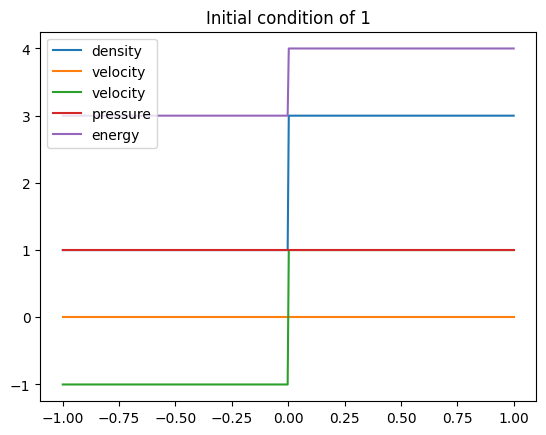

In [1]:
import matplotlib.pyplot as plt
import numpy as np

class problem():
    def __init__(self, n, gamma, kind):
        self.n = n
        self.gamma = gamma
        self.kind = kind
        if self.kind == 1:
            self.x_l = -1
            self.x_r = 1
        elif self.kind == 2:
            self.x_l = 0
            self.x_r = 1
       
    def rho_0(self, x):
        if self.kind == 1:
            return np.where(x<0, 1, 3)
        elif self.kind == 2:
            return np.ones_like(x)
        
    def u_0(self, x):
        return np.zeros_like(x)
    
    def v_0(self, x):
        if self.kind == 1:
            return np.where(x<0, -1, 1)
        elif self.kind == 2:
            return np.piecewise(x, [(0<=x)&(x<0.5), (0.5<=x)&(x<=1)], [-10,20])
        
    def p_0(self, x):
        if self.kind == 1:
            return np.ones_like(x)
        elif self.kind == 2:
            return np.piecewise(x, [(0<=x)&(x<0.1), (0.1<=x)&(x<0.9), (0.9<=x)&(x<=1)], [1000, 0.01, 100])
        
    def e_0(self, x):
        return self.p_0(x)/(self.gamma-1) + 0.5*self.rho_0(x)*(self.u_0(x)**2+self.v_0(x)**2)
    '''
    def u_l(self, t):
        if self.kind == 1:
            return self.u_0(self.x_l)
        elif self.kind == 2:
            return 0
    def u_r(self, t):
        if self.kind == 1:
            return self.u_0(self.x_r)
        elif self.kind == 2:
            return 0
    '''
    def q_0(self, x):
        return np.array([self.rho_0(x), self.rho_0(x)*self.u_0(x), self.rho_0(x)*self.v_0(x), self.e_0(x)])
    def f(self, q):
        return np.array([q[1], q[1]**2/q[0] + (self.gamma-1)*(q[3]-0.5*(q[1]**2/q[0]+q[2]**2/q[0])), q[1]*q[2]/q[0], q[1]*(q[3]+(self.gamma-1)*(q[3]-0.5*(q[1]**2/q[0]+q[2]**2/q[0])))/q[0]])

n = 400
kind = 1
Problem = problem(n, 1.4, kind)

#plot the initial condition
x = np.linspace(Problem.x_l, Problem.x_r, n)
rho_0 = np.zeros(n)
u_0 = np.zeros(n)
v_0 = np.zeros(n)
p_0 = np.zeros(n)
e_0 = np.zeros(n)
for i in range(n):
    rho_0[i] = Problem.rho_0(x[i])
    u_0[i] = Problem.u_0(x[i])
    v_0[i] = Problem.v_0(x[i])
    p_0[i] = Problem.p_0(x[i])
    e_0[i] = Problem.e_0(x[i])
plt.figure(1)
plt.plot(x, rho_0, label='density')
plt.plot(x, u_0, label='velocity')
plt.plot(x, v_0, label='velocity')
plt.plot(x, p_0, label='pressure')
plt.plot(x, e_0, label='energy')
plt.legend()
plt.title('Initial condition of {}'.format(Problem.kind))
plt.savefig('initial_condition_{}.png'.format(Problem.kind))
plt.show()
plt.close()

In [2]:
class HLLCsolver(problem):
    def __init__(self, n, gamma, kind, step):
        super().__init__(n, gamma, kind)
        self.dx = (self.x_r-self.x_l)/self.n
        if kind == 1:
            self.time = 4.0
        elif kind == 2:
            self.time = 0.040
        self.t = step
        self.dt = self.time/step
        self.Q = np.zeros((4, self.t, self.n+2))  #Q is the matrix of the solution
        self.x = np.linspace(self.x_l+self.dx/2, self.x_r-self.dx/2, self.n)
        self.Q[:, 0, 1:-1] = self.q_0(self.x)
        self.F = np.zeros((4, self.t, self.n+2))
        self.F_half = np.zeros((4, self.t, self.n+1))
        self.u = np.zeros((self.n+2))
        

        q_l_0 = self.q_0(self.x_l)
        q_r_0 = self.q_0(self.x_r)
        #reflective boundary condition
        q_l_0[1] = -q_l_0[1]
        q_r_0[1] = -q_r_0[1]

        self.Q[:, 0, 0] = q_l_0
        self.Q[:, 0, -1] = q_r_0

        self.lbd_L = np.zeros((self.n+1))
        self.lbd_R = np.zeros((self.n+1))
        self.lbd = np.zeros((self.n+1))

        '''
        '''

    def forward(self, inference_step):
        #update the lbd_L, lbd_R, lbd
        m = 0
        while m< inference_step-1:
            rho = self.Q[0,m,:]
            u = self.Q[1,m,:]/self.Q[0,m,:]
            v = self.Q[2,m,:]/self.Q[0,m,:]
            e = self.Q[3,m,:]
            p = (self.gamma-1)*(e-0.5*(u**2+v**2)*rho)

            #update the F
            self.F[:,m,:] = np.array([rho*u, rho*u**2+p, rho*u*v, u*(e+p)])
            c = np.sqrt(self.gamma*p/rho)

            for i in range(self.n+1):
                if 1<=i<=self.n-1:
                    self.lbd_L[i] = min(u[i]-c[i], u[i+1]-c[i+1])
                    self.lbd_R[i] = max(u[i]+c[i], u[i+1]+c[i+1])
                else:
                    self.lbd_L[i] = -np.abs(u[i])-c[i]
                    self.lbd_R[i] = np.abs(u[i])+c[i]
                
                self.lbd[i] = (self.lbd_R[i]*self.Q[1,m,i+1]-self.lbd_L[i]*self.Q[1,m,i]-self.F[1,m,i+1]+self.F[1,m,i])/\
                    (self.lbd_R[i]*rho[i+1]-self.lbd_L[i]*rho[i]-self.F[0,m,i+1]+self.F[0,m,i])
                
                #update the F_half
                if self.lbd_L[i] >= 0:
                    self.F_half[:,m,i] = self.F[:,m,i]  

                elif self.lbd_R[i] <= 0:
                    self.F_half[:,m,i] = self.F[:,m,i+1]

                elif self.lbd_L[i] < 0 and self.lbd[i] > 0:
                    rho_L = (self.lbd_L[i]-u[i])*rho[i]\
                        /(self.lbd_L[i]-self.lbd[i])
                    au_1 = self.lbd_L[i]/(self.lbd_L[i]-self.lbd[i])
                    e_L = au_1*e[i]+(au_1-1)*self.F[1,m,i]-self.F[3,m,i]/(self.lbd_L[i]-self.lbd[i])\
                    +au_1*self.lbd[i]**2*rho[i]-(2*au_1-1)*self.lbd[i]*rho[i]*u[i]
                    Q_L = np.array([rho_L, rho_L*self.lbd[i], rho_L*v[i], e_L])

                    self.F_half[:,m,i] = self.F[:,m,i] + self.lbd_L[i]*(Q_L-self.Q[:,m,i])
                    
                elif self.lbd_R[i] > 0 and self.lbd[i] <= 0:
                    rho_R = (self.lbd_R[i]-u[i+1])*rho[i+1]\
                        /(self.lbd_R[i]-self.lbd[i])
                    au_2 = self.lbd_R[i]/(self.lbd_R[i]-self.lbd[i])
                    e_R = au_2*e[i+1]+(au_2-1)*self.F[1,m,i+1]-self.F[3,m,i+1]/(self.lbd_R[i]-self.lbd[i])\
                    +au_2*self.lbd[i]**2*rho[i+1]-(2*au_2-1)*self.lbd[i]*rho[i+1]*u[i+1]
                    Q_R = np.array([rho_R, rho_R*self.lbd[i], rho_R*v[i+1], e_R])

                    self.F_half[:,m,i] = self.F[:,m,i+1] + self.lbd_R[i]*(Q_R-self.Q[:,m,i+1])
                
            #update Q
            #self.dt = self.dx/np.max(np.abs(self.lbd))
            self.Q[:,m+1,1:-1]=self.Q[:,m,1:-1]-self.dt/self.dx*(self.F_half[:,m,1:]-self.F_half[:,m,:-1])
            q_l = self.Q[:,m+1,1]
            q_r = self.Q[:,m+1,-2]
            #reflective boundary condition
            q_l[1] = -q_l[1]
            q_r[1] = -q_r[1]

            self.Q[:,m+1,0] = q_l
            self.Q[:,m+1,-1] = q_r
            m += 1
                
        return self.Q

In [45]:
n=500
kind = 2#1
Range = 2000
Instance = HLLCsolver(n, 1.4, kind, Range)
Q = Instance.forward(Range)

In [46]:
if kind == 1:
    time = [1,2,3]
elif kind == 2:
    time = [0.01,0.02,0.03,0.038]
steps = []
for k in time:
    step = int(k/Instance.time*Range)
    steps.append(step)    
steps

[500, 1000, 1500, 1900]

In [47]:
output = "output_{}".format(Instance.kind)
for t in steps:#range(0,Range,10):
    plt.figure(figsize=(20,16))
    plt.suptitle('t = {}'.format(t*Instance.dt))
    plt.subplot(2,2,1)
    plt.title('density')
    plt.plot(Instance.x, Q[0,t,1:-1], label='density')
    plt.subplot(2,2,2)
    plt.title('u')
    plt.plot(Instance.x, Q[1,t,1:-1]/Q[0,t,1:-1], label='velocity')
    if kind == 1:
        plt.gca().set_ylim(-1,1)
    plt.subplot(2,2,3)
    plt.title('v')
    plt.plot(Instance.x, Q[2,t,1:-1]/Q[0,t,1:-1], label='velocity')
    plt.subplot(2,2,4)
    plt.title('pressure')
    plt.plot(Instance.x, (Instance.gamma-1)*(Q[3,t,1:-1]-0.5*(Q[1,t,1:-1]**2/Q[0,t,1:-1]+Q[2,t,1:-1]**2/Q[0,t,1:-1])), label='pressure')
    plt.savefig('{}_{}'.format(kind, t))#(output+'/project2_{}_{}.png'.format(kind, t))
    plt.close()
    

In [105]:
from PIL import Image

images = []
for n in range(0, Range, 10):
    img_path = output + '/project2_{}_{}.png'.format(kind,n)
    images.append(Image.open(img_path))

output_gif_path = 'output_animation_{}.gif'.format(kind)
images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=100, loop=1)


In [38]:
#linear reconstruction
@staticmethod
def minmod(a, b):
        return 0.5 * (np.sign(a) + np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [25]:
class linear_rec_HLLCsolver(problem):
    def __init__(self, n, gamma, kind, step):
        super().__init__(n, gamma, kind)
        self.dx = (self.x_r-self.x_l)/self.n
        if kind == 1:
            self.time = 4.0
        elif kind == 2:
            self.time = 0.040
        self.t = step
        self.dt = self.time/step
        self.Q = np.zeros((4, self.t, self.n+4))  #Q is the matrix of the solution
        self.x = np.linspace(self.x_l+self.dx/2, self.x_r-self.dx/2, self.n)
        self.Q[:, 0, 2:-2] = self.q_0(self.x)
        self.F = np.zeros((4, self.t, self.n+2))
        self.F_half = np.zeros((4, self.t, self.n+1))
        self.u = np.zeros((self.n+2))
    
        #reflective boundary condition

        self.Q[:, 0, 1] = self.Q[:, 0, 2]
        self.Q[:,0, 0] = self.Q[:,0, 3]
        self.Q[:, 0, -2] = self.Q[:, 0, -3]
        self.Q[:,0, -1] = self.Q[:,0, -4]

        self.Q[1, 0, 1] = -self.Q[1, 0, 2]
        self.Q[1,0, 0] = -self.Q[1,0, 3]
        self.Q[1, 0, -2] = -self.Q[1, 0, -3]
        self.Q[1,0, -1] = -self.Q[1,0, -4]

        self.Q_original = np.copy(self.Q)

        self.lbd_L = np.zeros((self.n+1))
        self.lbd_R = np.zeros((self.n+1))
        self.lbd = np.zeros((self.n+1))

    def RHS(self, m):
        difference_Q = (self.Q[:, m, 1:] - self.Q[:, m, :-1])/self.dx
        sigma = minmod(difference_Q[:, 1:], difference_Q[:, :-1])
        self.Q_rec = self.Q[:, m, 1:-1] + 0.5*sigma*self.dx
        self.Q_rec_1 = self.Q[:, m, 1:-1] - 0.5*sigma*self.dx
    
        rho = np.array([self.Q_rec[0,:], self.Q_rec_1[0,:]])
        u = np.array([self.Q_rec[1,:]/self.Q_rec[0,:], self.Q_rec_1[1,:]/self.Q_rec_1[0,:]])
        v = np.array([self.Q_rec[2,:]/self.Q_rec[0,:], self.Q_rec_1[2,:]/self.Q_rec_1[0,:]])
        e = np.array([self.Q_rec[3,:], self.Q_rec_1[3,:]])
        p = (self.gamma-1)*(e-0.5*(u**2+v**2)*rho)
        #update the F
        self.F_rec = np.array([rho[0]*u[0], rho[0]*u[0]**2+p[0], rho[0]*u[0]*v[0], u[0]*(e[0]+p[0])])
        self.F_rec1 = np.array([rho[1]*u[1], rho[1]*u[1]**2+p[1], rho[1]*u[1]*v[1], u[1]*(e[1]+p[1])])
        c = np.sqrt(np.abs(self.gamma*p/rho))#here due to small oscilation, use abs to avoid the negative value, so small that it can be ignored.

        for i in range(self.n+1):
            self.lbd_L[i] = min(u[0][i]-c[0][i], u[1][i+1]-c[1][i+1])
            self.lbd_R[i] = max(u[0][i]+c[0][i], u[1][i+1]+c[1][i+1])

            self.lbd[i] = (self.lbd_R[i]*self.Q_rec_1[1,i+1]-self.lbd_L[i]*self.Q_rec[1,i]-self.F_rec1[1,i+1]+self.F_rec[1,i])/\
                (self.lbd_R[i]*rho[1][i+1]-self.lbd_L[i]*rho[0][i]-self.F_rec1[0,i+1]+self.F_rec[0,i])
                
            #update the F_half
            if self.lbd_L[i] >= 0:
                self.F_half[:,m,i] = self.F_rec[:,i]  

            elif self.lbd_R[i] <= 0:
                self.F_half[:,m,i] = self.F_rec1[:,i+1]

            elif self.lbd_L[i] < 0 and self.lbd[i] > 0:
                rho_L = (self.lbd_L[i]-u[0][i])*rho[0][i]\
                    /(self.lbd_L[i]-self.lbd[i])
                au_1 = self.lbd_L[i]/(self.lbd_L[i]-self.lbd[i])
                e_L = au_1*e[0][i]+(au_1-1)*self.F_rec[1,i]-self.F_rec[3,i]/(self.lbd_L[i]-self.lbd[i])\
                +au_1*self.lbd[i]**2*rho[0][i]-(2*au_1-1)*self.lbd[i]*rho[0][i]*u[0][i]
                Q_L = np.array([rho_L, rho_L*self.lbd[i], rho_L*v[0][i], e_L])

                self.F_half[:,m,i] = self.F_rec[:,i] + self.lbd_L[i]*(Q_L-self.Q_rec[:,i])
                    
            elif self.lbd_R[i] > 0 and self.lbd[i] <= 0:
                rho_R = (self.lbd_R[i]-u[1][i+1])*rho[1][i+1]\
                    /(self.lbd_R[i]-self.lbd[i])
                au_2 = self.lbd_R[i]/(self.lbd_R[i]-self.lbd[i])
                e_R = au_2*e[1][i+1]+(au_2-1)*self.F_rec1[1,i+1]-self.F_rec1[3,i+1]/(self.lbd_R[i]-self.lbd[i])\
                +au_2*self.lbd[i]**2*rho[1][i+1]-(2*au_2-1)*self.lbd[i]*rho[1][i+1]*u[1][i+1]
                Q_R = np.array([rho_R, rho_R*self.lbd[i], rho_R*v[1][i+1], e_R])

                self.F_half[:,m,i] = self.F_rec1[:,i+1] + self.lbd_R[i]*(Q_R-self.Q_rec_1[:,i+1])
                
        #update Q
        #self.dt = self.dx/np.max(np.abs(self.lbd)
        RHS = -1/self.dx*(self.F_half[:,m,1:]-self.F_half[:,m,:-1])
        return RHS
    
    def forward(self, inference_step):
        #update the lbd_L, lbd_R, lbd
        m = 0
        while m< inference_step-1:
            #Use midpoint method to update the Q
            
            RHS_1 = self.RHS(m)
            self.Q[:,m,2:-2] = self.Q_original[:,m,2:-2] + self.dt/2*RHS_1
            #reflective boundary condition

            self.Q[:, m, 1] = self.Q[:, m, 2]
            self.Q[:,m, 0] = self.Q[:,m, 3]
            self.Q[:, m, -2] = self.Q[:, m, -3]
            self.Q[:,m, -1] = self.Q[:,m, -4]

            self.Q[1, m, 1] = -self.Q[1, m, 2]
            self.Q[1,m, 0] = -self.Q[1,m, 3]
            self.Q[1, m, -2] = -self.Q[1, m, -3]
            self.Q[1,m, -1] = -self.Q[1,m, -4]
            
            RHS_2 = self.RHS(m)
            self.Q[:,m+1,2:-2] = self.Q_original[:,m,2:-2] + self.dt*RHS_2
            #reflective boundary condition
            self.Q[:, m+1, 1] = self.Q[:, m+1, 2]
            self.Q[:,m+1, 0] = self.Q[:,m+1, 3]
            self.Q[:, m+1, -2] = self.Q[:, m+1, -3]
            self.Q[:,m+1, -1] = self.Q[:,m+1, -4]

            self.Q[1, m+1, 1] = -self.Q[1, m+1, 2]
            self.Q[1,m+1, 0] = -self.Q[1,m+1, 3]
            self.Q[1, m+1, -2] = -self.Q[1, m+1, -3]
            self.Q[1,m+1, -1] = -self.Q[1,m+1, -4]

            m += 1

            self.Q_original[:,m,:] = np.copy(self.Q[:,m,:])

        return self.Q_original
            

In [29]:
n=500
kind = 2#1
Range = 2000
Instance = linear_rec_HLLCsolver(n, 1.4, kind, Range)
Q = Instance.forward(Range)

In [32]:
if kind == 1:
    time = [1,2,3]
elif kind == 2:
    time = [0.01,0.02,0.03,0.038]
steps = []
for k in time:
    step = int(k/Instance.time*Range)
    steps.append(step)    
steps

[500, 1000, 1500, 1900]

In [33]:
output = "rec_output_{}".format(Instance.kind)
for t in steps:#range(0,Range,10):
    plt.figure(figsize=(20,16))
    plt.suptitle('t = {}'.format(t*Instance.dt))
    plt.subplot(2,2,1)
    plt.title('density')
    plt.plot(Instance.x, Q[0,t,2:-2], label='density')
    plt.subplot(2,2,2)
    plt.title('u')
    plt.plot(Instance.x, Q[1,t,2:-2]/Q[0,t,2:-2], label='velocity')
    if kind == 1:
        plt.gca().set_ylim(-1,1)
    plt.subplot(2,2,3)
    plt.title('v')
    plt.plot(Instance.x, Q[2,t,2:-2]/Q[0,t,2:-2], label='velocity')
    plt.subplot(2,2,4)
    plt.title('pressure')
    plt.plot(Instance.x, (Instance.gamma-1)*(Q[3,t,2:-2]-0.5*(Q[1,t,2:-2]**2/Q[0,t,2:-2]+Q[2,t,2:-2]**2/Q[0,t,2:-2])), label='pressure')
    plt.savefig('rec_{}_{}'.format(kind, t))#(output+'/project2_{}_{}.png'.format(kind, t))
    plt.close()
    

In [117]:
from PIL import Image

images = []
for n in range(0, Range, 10):
    img_path = output + '/rec_project2_{}_{}.png'.format(kind,n)
    images.append(Image.open(img_path))

output_gif_path = 'rec_output_animation_{}.gif'.format(kind)
images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=100, loop=1)
